In [1]:
import numpy as np
from scipy.optimize import linprog
import networkx as nx
import matplotlib.pyplot as plt

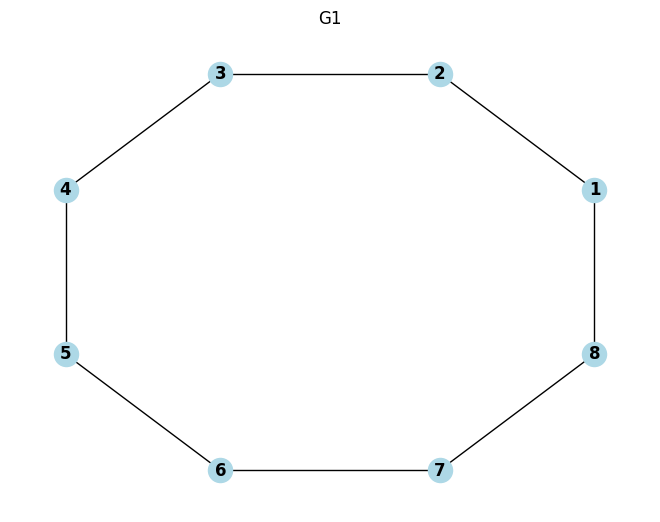

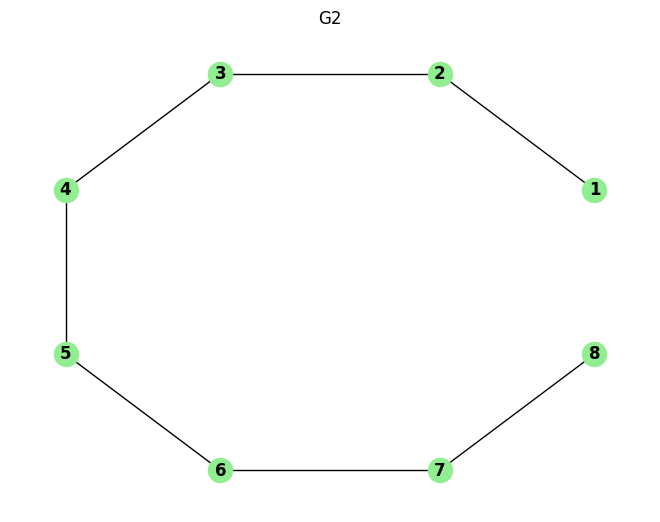

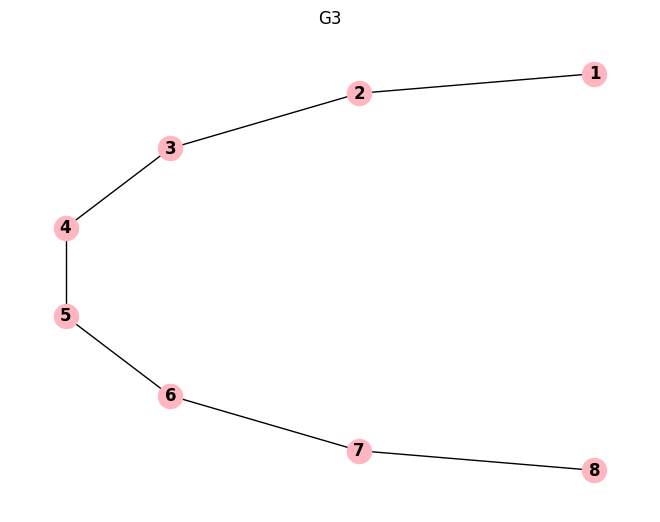

In [2]:
# Setup graphs
G1 = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 1)])
d1 = np.zeros((8, 2))
for i in range(8):
    d1[i, 0] = np.cos(np.pi / 8 + np.pi / 4 * i)
    d1[i, 1] = np.sin(np.pi / 8 + np.pi / 4 * i)

G2 = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)])
d2 = d1.copy()

G3 = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)])
d3 = np.zeros((8, 2))
for i in range(8):
    d3[i, 0] = np.cos(np.pi / 2 + np.pi / 7 * i)
    d3[i, 1] = np.sin(np.pi / 2 + np.pi / 7 * i)

# Get adjacency matrices
A1 = nx.adjacency_matrix(G1).todense()
A2 = nx.adjacency_matrix(G2).todense()
A3 = nx.adjacency_matrix(G3).todense()

# Numbers of nodes of G1, G2, G3
n = 8

# Get transition matrices
P1 = A1 / np.sum(A1, axis=1)
P2 = A2 / np.sum(A2, axis=1)
P3 = A3 / np.sum(A3, axis=1)

# Get distributions (omitted for now, will be implemented later)

# Get cost matrices (omitted for now, will be implemented later)

# Other algorithms like exact_otc, computeot_lp, fgw_dist (omitted for now, will be implemented later)

# Fix the node position mapping to start from 1 instead of 0
# Plot graphs again
plt.figure()
nx.draw(G1, pos={i+1: d1[i] for i in range(n)}, with_labels=True, node_color='lightblue', font_weight='bold')
plt.title('G1')
plt.figure()
nx.draw(G2, pos={i+1: d2[i] for i in range(n)}, with_labels=True, node_color='lightgreen', font_weight='bold')
plt.title('G2')
plt.figure()
nx.draw(G3, pos={i+1: d3[i] for i in range(n)}, with_labels=True, node_color='lightpink', font_weight='bold')
plt.title('G3')

plt.show()


# The code above is a partial translation. The algorithms like exact_otc, computeot_lp, and fgw_dist are yet to be implemented.


In [3]:
def approx_stat_dist(P, iter):
    n = P.shape[0]
    dist = np.zeros(n)
    dist[0] = 1
    for i in range(iter):
        dist = np.dot(dist, P)
    return dist

# Testing the function with a dummy matrix
P_test = np.array([[0.5, 0.5, 0], [0, 0.5, 0.5], [0.5, 0, 0.5]])
approx_stat_dist(P_test, 100)


array([0.33333333, 0.33333333, 0.33333333])

# **computeot_lp**

In [4]:
from scipy.optimize import linprog

def computeot_lp(C, r, c):
    nx = len(r)
    ny = len(c)
    A_eq = np.zeros((nx + ny, nx * ny))
    b_eq = np.concatenate([r, c])

    for row in range(nx):
        for t in range(ny):
            A_eq[row, row * ny + t] = 1

    for row in range(nx, nx + ny):
        for t in range(nx):
            A_eq[row, (row - nx) + t * ny] = 1

    lb = np.zeros(nx * ny)

    cost = C.reshape(nx * ny)
    res = linprog(cost, A_eq=A_eq, b_eq=b_eq, bounds=[(0, None) for _ in range(nx * ny)], method='highs')

    return res.x, res.fun

# Testing the function with a dummy matrix
C_test = np.array([[1, 2], [3, 4]])
r_test = np.array([0.4, 0.6])
c_test = np.array([0.3, 0.7])
computeot_lp(C_test, r_test, c_test)


(array([0. , 0.4, 0.3, 0.3]), 2.9)

# **get_best_stat_dist**

In [5]:
np.random.seed(0)  # For reproducibility
n = 5  # Number of nodes
P_test = np.random.rand(n, n)
P_test = P_test / P_test.sum(axis=1, keepdims=True)  # Normalizing to make it a transition matrix
C_test = np.random.rand(n, n)  # Random cost matrix
# Revising the get_best_stat_dist function to align with the mathematical problem it's solving
# Fix the bounds issue in the get_best_stat_dist function
def get_best_stat_dist(P, c):
    n = P.shape[0]  # Number of states
    c_flat = c.flatten()
    I_n = np.eye(n)
    ones_row = np.ones((1, n))
    A_eq = np.block([[I_n - P], [ones_row]])
    b_eq = np.concatenate([np.zeros(n), [1]])
    
    # Fix the bounds to match the size of c_flat
    bounds = [(0, None) for _ in range(len(c_flat))]
    
    res = linprog(c_flat, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    if res.success:
        stat_dist = res.x
        exp_cost = res.fun
    else:
        raise Exception('Failed to compute stationary distribution.')
    return stat_dist, exp_cost



# # Re-testing the get_best_stat_dist function with corrected implementation
# try:
#     stat_dist_test, exp_cost_test = get_best_stat_dist(P_test, C_test)
#     print("Stationary distribution:", stat_dist_test)
#     print("Expected cost:", exp_cost_test)
# except Exception as e:
#     print("An error occurred:", str(e))


# **get_ind_tc**

In [6]:
# Define all required sub-functions and the main function for exact_otc

def get_ind_tc(Px, Py):
    dx, dx_col = Px.shape
    dy, dy_col = Py.shape
    P_ind = np.zeros((dx * dy, dx_col * dy_col))
    for x_row in range(dx):
        for x_col in range(dx_col):
            for y_row in range(dy):
                for y_col in range(dy_col):
                    idx1 = dy * (x_row) + y_row
                    idx2 = dy * (x_col) + y_col
                    P_ind[idx1, idx2] = Px[x_row, x_col] * Py[y_row, y_col]
    return P_ind
# Test the function
np.random.seed(0)
Px_test = np.array([[0.2, 0.3, 0.5], [0.1, 0.7, 0.2], [0.4, 0.4, 0.2]])
Py_test = np.array([[0.5, 0.2, 0.3], [0.3, 0.5, 0.2], [0.2, 0.3, 0.5]])

P_ind_result = get_ind_tc(Px_test, Py_test)
P_ind_result

array([[0.1 , 0.04, 0.06, 0.15, 0.06, 0.09, 0.25, 0.1 , 0.15],
       [0.06, 0.1 , 0.04, 0.09, 0.15, 0.06, 0.15, 0.25, 0.1 ],
       [0.04, 0.06, 0.1 , 0.06, 0.09, 0.15, 0.1 , 0.15, 0.25],
       [0.05, 0.02, 0.03, 0.35, 0.14, 0.21, 0.1 , 0.04, 0.06],
       [0.03, 0.05, 0.02, 0.21, 0.35, 0.14, 0.06, 0.1 , 0.04],
       [0.02, 0.03, 0.05, 0.14, 0.21, 0.35, 0.04, 0.06, 0.1 ],
       [0.2 , 0.08, 0.12, 0.2 , 0.08, 0.12, 0.1 , 0.04, 0.06],
       [0.12, 0.2 , 0.08, 0.12, 0.2 , 0.08, 0.06, 0.1 , 0.04],
       [0.08, 0.12, 0.2 , 0.08, 0.12, 0.2 , 0.04, 0.06, 0.1 ]])

# **exact_tce & exact_tci & exact_otc**

In [7]:

def exact_tce(P, c):
    d = P.shape[0]
    c = c.reshape((d, -1))
    A = np.block([[np.eye(d) - P, np.zeros((d, d)), np.zeros((d, d))],
                  [np.eye(d), np.eye(d) - P, np.zeros((d, d))],
                  [np.zeros((d, d)), np.eye(d), np.eye(d) - P]])
    b = np.concatenate([np.zeros(d), c.flatten(), np.zeros(d)])
    sol = np.linalg.lstsq(A, b, rcond=None)[0]
    g = sol[:d]
    h = sol[d:2*d]
    return g, h

# Completing the exact_tci function by adding the part to improve with respect to h

def exact_tci(g, h, P0, Px, Py):
    x_sizes = Px.shape
    y_sizes = Py.shape
    dx = x_sizes[0]
    dy = y_sizes[0]
    P = np.zeros((dx * dy, dx * dy))
    
    # Try to improve with respect to g
    g_const = np.all(np.isclose(g, g[0], atol=1e-3))
    
    if not g_const:
        g_mat = g.reshape((dy, dx)).T
        for x_row in range(dx):
            for y_row in range(dy):
                dist_x = Px[x_row, :]
                dist_y = Py[y_row, :]
                if np.any(dist_x == 1) or np.any(dist_y == 1):
                    sol = np.outer(dist_x, dist_y).flatten()
                else:
                    sol, _ = computeot_lp(g_mat.T.flatten(), dist_x, dist_y)
                idx = dy * (x_row) + y_row
                P[idx, :] = sol.reshape((-1, dx * dy))
        if np.max(np.abs(np.dot(P0, g) - np.dot(P, g))) <= 1e-7:
            P = P0

    # Try to improve with respect to h
    h_mat = h.reshape((dy, dx)).T
    for x_row in range(dx):
        for y_row in range(dy):
            dist_x = Px[x_row, :]
            dist_y = Py[y_row, :]
            if np.any(dist_x == 1) or np.any(dist_y == 1):
                sol = np.outer(dist_x, dist_y).flatten()
            else:
                sol, _ = computeot_lp(h_mat.T.flatten(), dist_x, dist_y)
            idx = dy * (x_row) + y_row
            P[idx, :] = sol.reshape((-1, dx * dy))
            
    if np.max(np.abs(np.dot(P0, h) - np.dot(P, h))) <= 1e-4:
        P = P0
    
    return P

# Placeholder for testing the function
# exact_tci(g_test, h_test, P0_test, Px_test, Py_test)

def exact_otc(Px, Py, c):
    dx = Px.shape[0]
    dy = Py.shape[0]
    
    P_old = np.ones((dx * dy, dx * dy))
    P = get_ind_tc(Px, Py)
    
    iter_ctr = 0
    while np.max(np.abs(P - P_old)) > 1e-10:
        iter_ctr += 1
        P_old = P
        g, h = exact_tce(P, c)
        # The following line is a placeholder. The function exact_tci needs to be implemented.
        P = exact_tci(g, h, P_old, Px, Py)
        # Check for convergence (placeholder)
        if np.all(P == P_old):
            stat_dist, exp_cost = get_best_stat_dist(P, c)
            return stat_dist.reshape((dy, dx)).T, exp_cost

# Generating some test data for exact_tce and exact_tci functions
np.random.seed(1)  # For reproducibility
dx, dy = 4, 4  # Number of nodes in the two graphs
Px_test = np.random.rand(dx, dx)
Px_test = Px_test / Px_test.sum(axis=1, keepdims=True)  # Normalizing to make it a transition matrix
Py_test = np.random.rand(dy, dy)
Py_test = Py_test / Py_test.sum(axis=1, keepdims=True)  # Normalizing to make it a transition matrix
P0_test = np.random.rand(dx * dy, dx * dy)
P0_test = P0_test / P0_test.sum(axis=1, keepdims=True)  # Normalizing to make it a transition matrix
c_test = np.random.rand(dx, dy)  # Random cost matrix

# Testing the exact_tce function
try:
    g_test, h_test = exact_tce(P0_test, c_test)
    print("Output vector g:", g_test)
    print("Output vector h:", h_test)
except Exception as e:
    print("An error occurred in exact_tce:", str(e))

Output vector g: [0.52957951 0.52957951 0.52957951 0.52957951 0.52957951 0.52957951
 0.52957951 0.52957951 0.52957951 0.52957951 0.52957951 0.52957951
 0.52957951 0.52957951 0.52957951 0.52957951]
Output vector h: [-0.00283199  0.24423448  0.02609992  0.18356361  0.01466056  0.0125318
 -0.173438   -0.48674132 -0.16015809 -0.45532003  0.45498359 -0.30898038
  0.29875254  0.32317253  0.16116602  0.03401191]


In [8]:
# Implementing the fgw_dist function

def fgw_dist(M, C1, C2, mu1, mu2, q, alpha):
    def fgw_loss(pi):
        loss = (1 - alpha) * np.sum(M ** q * pi)
        m, n = pi.shape
        for i in range(m):
            for j in range(n):
                for k in range(m):
                    for l in range(n):
                        loss += 2 * alpha * abs(C1[i, k] - C2[j, l]) ** q * pi[i, j] * pi[k, l]
        return loss

    def fgw_grad(pi):
        grad = (1 - alpha) * (M ** q)
        m, n = pi.shape
        for i in range(m):
            for j in range(n):
                for k in range(m):
                    for l in range(n):
                        grad[i, j] += 2 * alpha * abs(C1[i, k] - C2[j, l]) ** q * pi[k, l]
        return grad

    pi = mu1[:, None] * mu2[None, :]
    m, n = pi.shape

    n_iter = 100
    for iter in range(n_iter):
        G = fgw_grad(pi)
        pi_new, _ = computeot_lp(G.flatten(), mu1, mu2)
        pi_new = pi_new.reshape((n, m)).T

        fun = lambda tau: fgw_loss((1 - tau) * pi + tau * pi_new)
        tau_values = np.linspace(0, 1, 11)
        tau = tau_values[np.argmin([fun(t) for t in tau_values])]

        pi = (1 - tau) * pi + tau * pi_new

    FGW = fgw_loss(pi)
    return FGW, pi

# Placeholder for testing the function
# fgw_dist(M_test, C1_test, C2_test, mu1_test, mu2_test, q_test, alpha_test)


In [9]:
# Re-try testing the exact_otc function
try:
    stat_dist_result, exp_cost_result = exact_otc(Px_test, Py_test, c_test)
    print("Stationary distribution:", stat_dist_result)
    print("Expected cost:", exp_cost_result)
except Exception as e:
    print("An error occurred:", str(e))


Stationary distribution: [[0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]]
Expected cost: 0.5379813085004425


G2 vs G1 - OTC distance: [[-0.       0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125]
 [ 0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125 -0.     ]
 [-0.       0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125]
 [ 0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125 -0.     ]
 [-0.       0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125]
 [ 0.03125 -0.       0.03125 -0.       0.03125  0.       0.03125 -0.     ]
 [-0.       0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125]
 [ 0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125 -0.     ]]
G2 vs G1 - OTSD distance: 0.2856898614864044
G2 vs G1 - FGW distance: 0.03125
G2 vs G3 - OTC distance: [[ 0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125 -0.     ]
 [-0.       0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125]
 [ 0.03125 -0.       0.03125 -0.       0.03125 -0.       0.03125 -0.     ]
 [-0.       0.03125 -0.       0.03125 -0.     

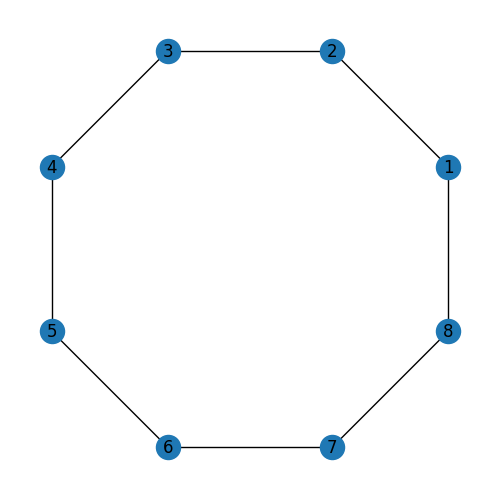

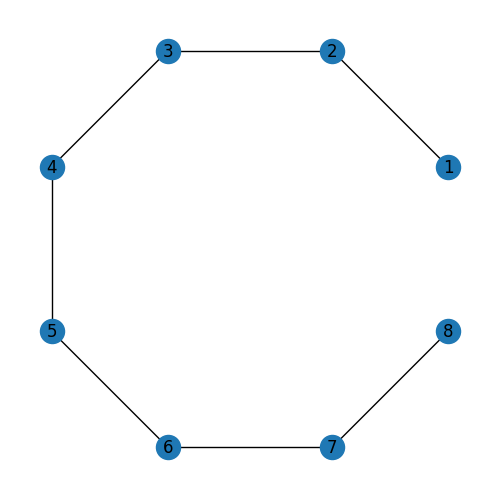

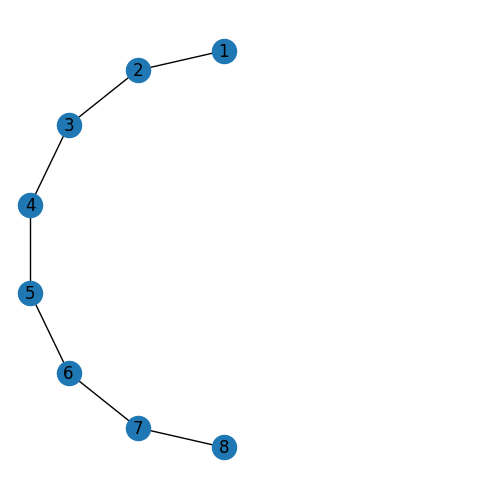

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import os

# Setup graphs
edges1 = [(i, i+1) for i in range(1, 8)] + [(8, 1)]
edges2 = [(i, i+1) for i in range(1, 7)] + [(7, 8)]
edges3 = edges2

G1 = nx.Graph(edges1)
G2 = nx.Graph(edges2)
G3 = nx.Graph(edges3)

d1 = np.zeros((8, 2))
d2 = np.zeros((8, 2))
d3 = np.zeros((8, 2))

for i in range(8):
    d1[i, 0] = np.cos(np.pi/8 + np.pi/4 * i)
    d1[i, 1] = np.sin(np.pi/8 + np.pi/4 * i)
    d2[i, 0] = d1[i, 0]
    d2[i, 1] = d1[i, 1]
    d3[i, 0] = np.cos(np.pi/2 + np.pi/7 * i)
    d3[i, 1] = np.sin(np.pi/2 + np.pi/7 * i)

# Get adjacency matrices
A1 = nx.adjacency_matrix(G1).toarray()
A2 = nx.adjacency_matrix(G2).toarray()
A3 = nx.adjacency_matrix(G3).toarray()

# Get transition matrices
P1 = A1 / np.sum(A1, axis=1)[:, np.newaxis]
P2 = A2 / np.sum(A2, axis=1)[:, np.newaxis]
P3 = A3 / np.sum(A3, axis=1)[:, np.newaxis]

# Get distributions
stat_dist1 = approx_stat_dist(P1, 100)
stat_dist2 = approx_stat_dist(P2, 100)
stat_dist3 = approx_stat_dist(P3, 100)

unif_dist1 = np.ones(8) / 8
unif_dist2 = np.ones(8) / 8
unif_dist3 = np.ones(8) / 8

# Get cost matrices
c1 = np.zeros((8, 8))
c2 = np.zeros((8, 8))

for i in range(8):
    for j in range(8):
        c1[i, j] = np.sum((d2[i, :] - d1[j, :]) ** 2)
        c2[i, j] = np.sum((d2[i, :] - d3[j, :]) ** 2)

# Run algorithm
otc_distance1, _ = exact_otc(P2, P1, c1)
_, otsd_distance1 = computeot_lp(c1.T, stat_dist2, stat_dist1)
fgw_distance1, _ = fgw_dist(c1, A2, A1, unif_dist2, unif_dist1, 1, 0.5)

otc_distance2, _ = exact_otc(P2, P3, c2)
_, otsd_distance2 = computeot_lp(c2.T, stat_dist2, stat_dist3)
fgw_distance2, _ = fgw_dist(c2, A2, A3, unif_dist2, unif_dist3, 1, 0.5)

# Display distances
print("G2 vs G1 - OTC distance:", otc_distance1)
print("G2 vs G1 - OTSD distance:", otsd_distance1)
print("G2 vs G1 - FGW distance:", fgw_distance1)

print("G2 vs G3 - OTC distance:", otc_distance2)
print("G2 vs G3 - OTSD distance:", otsd_distance2)
print("G2 vs G3 - FGW distance:", fgw_distance2)

# Plot graphs
savedir = '/mnt/data/NetOTC/experiments/plot/'
os.makedirs(savedir, exist_ok=True)

plt.figure()
nx.draw(G1, pos={i+1: (d1[i, 0], d1[i, 1]) for i in range(8)}, with_labels=True)
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.axis('square')
plt.savefig(savedir + 'circle_G1.png')

plt.figure()
nx.draw(G2, pos={i+1: (d2[i, 0], d2[i, 1]) for i in range(8)}, with_labels=True)
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.axis('square')
plt.savefig(savedir + 'circle_G2.png')

plt.figure()
nx.draw(G3, pos={i+1: (d3[i, 0], d3[i, 1]) for i in range(8)}, with_labels=True)
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.axis('square')
plt.savefig(savedir + 'circle_G3.png')


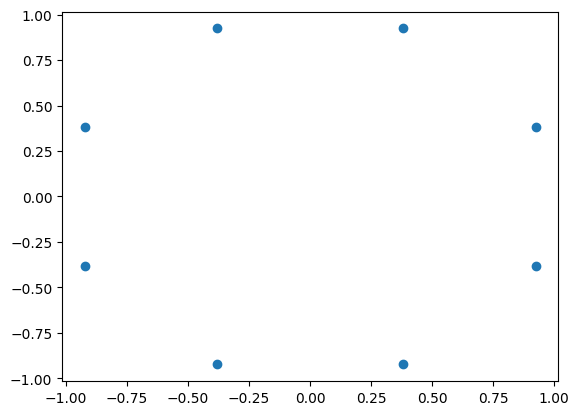

In [14]:
plt.scatter(*d1.T)
plt.show()

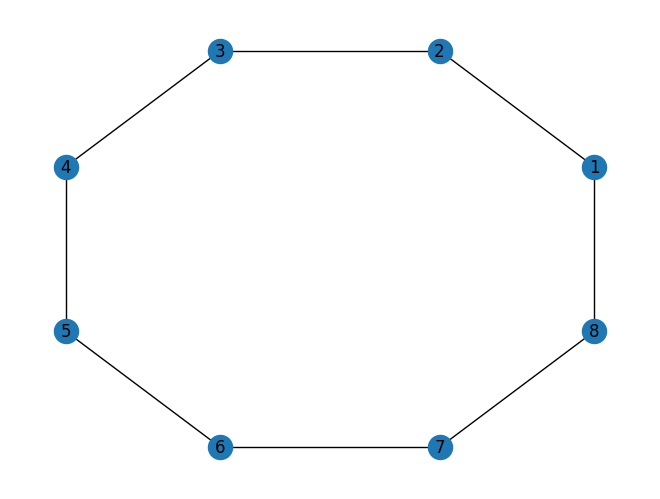

In [11]:
plt.figure()
nx.draw(G1, pos={i+1: (d1[i, 0], d1[i, 1]) for i in range(8)}, with_labels=True)